#### Convolution CNN for leaning images and processing - using high-level Keras preprocessing utilities and layers to read a directory of images on disk.

https://www.tensorflow.org/tutorials/load_data/images

#### deep_learn1.ipynb - was run for 1 year images.

In [68]:
import warnings
warnings.filterwarnings('ignore')

In [118]:
import numpy as np
import os
import PIL
from PIL import Image
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

In [70]:
print(tf.__version__)

2.5.0


#### Dataset
candlesticks/<br />
    buy<br />
    sell<br />

##### Define path for dataset

In [71]:
import pathlib
data_dir = pathlib.Path('candlesticks')
data_test_dir = pathlib.Path('candlesticks_test')

##### Validate total candlestick counts

In [72]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

52


In [73]:
image_test_count = len(list(data_test_dir.glob('*/*.png')))
print(image_test_count)

2


##### Read a sample buy image

In [74]:
candlesticks_buy = list(data_dir.glob('buy/*.png'))
PIL.Image.open(str(candlesticks[0]))
#PIL.Image.open(str(candlesticks[0])).size
candlesticks_sell = (list(data_dir.glob('sell/*.png')))

In [75]:
candlesticks_all = candlesticks_buy + candlesticks_sell

In [76]:
len(candlesticks_all)

52

In [77]:
candlesticks_test_buy = list(data_test_dir.glob('buy/*.png'))
candlesticks_test_sell = list(data_test_dir.glob('sell/*.png'))
candlesticks_test_all = candlesticks_test_buy + candlesticks_test_sell

In [78]:
candlesticks_test_all

[WindowsPath('candlesticks_test/buy/2021-07-25.png'),
 WindowsPath('candlesticks_test/sell/2021-07-18.png')]

### Load using tf.keras.preprocessing.ipynb_checkpoints/

#### Create a dataset

##### Define some parameters for the loader:

In [79]:
#batch_size = 1
img_height = 255
img_width = 255

##### It's good practice to use a validation split when developing your model. Will use 80% of the images for training and 20% for validation.

In [130]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width)
#  batch_size=batch_size
)

Found 53 files belonging to 2 classes.
Using 43 files for training.


In [131]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width)
  #batch_size=batch_size
)

Found 53 files belonging to 2 classes.
Using 10 files for validation.


##### You can find the class names in the class_names attribute on these datasets.

In [132]:
class_names = train_ds.class_names
print(class_names)

['buy', 'sell']


### Visualize the data

##### Here are the first 9 images from the training dataset.

In [133]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(2):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

##### we wil train a model using these datasets by passing them to model.fit. You can also manually iterate over the dataset and retrieve batches of images:

In [134]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 255, 255, 3)
(32,)


##### The image_batch is a tensor of the shape (1, 180, 180, 3). This is a batch of 1 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (1,), these are the corresponding labels to the 32 images.

### Standardize the data

##### The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using the tf.keras.layers.experimental.preprocessing.Rescaling layer.

In [135]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

##### There are two ways to use this layer. You can apply it to the dataset by calling map:

In [136]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8575005


##### Or, you can include the layer inside your model definition to simplify deployment. We will use the second approach here.

### Configure the dataset for performance

Let's make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

.prefetch() overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the data performance guide.

In [137]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared. This model has not been tuned in any way - the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit this tutorial.

In [147]:
num_classes = 2

model = tf.keras.Sequential([
#  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [148]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=False)

training_set = train_datagen.flow_from_directory(
            data_dir,
            target_size=(128, 128),
            batch_size=32,
            class_mode='categorical')

validation_set = train_datagen.flow_from_directory(
            data_dir,
            target_size=(128, 128),
            batch_size=32,
            class_mode='categorical')

Found 53 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


```python 
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
            '/content/drive/My Drive/Colab Notebooks/dataset',
            target_size=(128, 128),
            batch_size=30,
            class_mode='categorical')

# test_set = test_datagen.flow_from_directory(
#             '../dataset/test_set/',
#             target_size=(64, 64),
#             batch_size=32,
#             class_mode='binary')

classifier.fit_generator(
            training_set,
            steps_per_epoch=40,
            epochs=10,
            validation_data=training_set,
            validation_steps=80)
```

In [149]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy', #tf.losses.categorical_crossentropy(from_logits=True),
  metrics=['accuracy'])

In [150]:
import matplotlib.pyplot as plt

In [151]:
len(training_set[0][0])

32

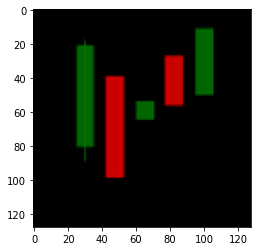

In [152]:
plt.imshow(training_set.next()[0][0])

In [153]:
model.fit(
            training_set, 
#            train_ds,
            steps_per_epoch=1,
            epochs=20,
#            validation_split=.1
#            validation_data=validation_set
#            validation_data=training_set,
#            validation_steps=80
)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.6875 - accuracy: 0.6250
Epoch 2/20
1/1 [==============================] - 1s 639ms/step - loss: 0.6614 - accuracy: 0.6190
Epoch 3/20
1/1 [==============================] - 1s 679ms/step - loss: 0.5407 - accuracy: 0.7500
Epoch 4/20
1/1 [==============================] - 1s 708ms/step - loss: 0.5155 - accuracy: 0.7188
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 0.5435 - accuracy: 0.6562
Epoch 6/20
1/1 [==============================] - 1s 598ms/step - loss: 0.5815 - accuracy: 0.6667
Epoch 7/20
1/1 [==============================] - 1s 659ms/step - loss: 0.3687 - accuracy: 0.9048
Epoch 8/20
1/1 [==============================] - 1s 552ms/step - loss: 0.5378 - accuracy: 0.7619
Epoch 9/20
1/1 [==============================] - 0s 444ms/step - loss: 0.3872 - accuracy: 0.8571
Epoch 10/20
1/1 [==============================] - 1s 756ms/step - loss: 0.3908 - accuracy: 0.8438
Epoch 11/20
1/1 [========

In [127]:
model.fit(
  train_ds,
#  validation_data=val_ds,
  epochs=10,
#  verbose='2'
)

Epoch 1/10


TypeError: 'NoneType' object is not callable

In [96]:
#model.evaluate(X_test, y_test, verbose=0)

In [97]:
#model.evaluate(train_ds)

In [98]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

### Predict the next candlesticks

In [113]:
from skimage.transform import rescale, resize
import numpy as np
from keras.preprocessing import image

def predict_chart(img):
    plt.imshow(img)
    plt.show()
    
    test_image = np.expand_dims(img, axis=0)
    pred = model.predict_classes(test_image)[[0]]
    
    if (pred == 0):
        print('Sell', pred)
    elif (pred == 1):
        print('Buy', pred)

In [119]:
for i in range(len(candlesticks_test_all)):
    print(candlesticks_test_all[i])
    image = Image.open(candlesticks_test_all[i])
    print(image.format)
    print(image.mode)
    print(image.size)
    #predict_chart(image)
    img_array = keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = predictions[0]
    print(
    "This image is %.2f percent Buy and %.2f percent Sell."
    % (100 * (1 - score), 100 * score)
)

candlesticks_test\buy\2021-07-25.png
PNG
RGBA
(640, 480)


ValueError: in user code:

    C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1569 predict_function  *
        return step_function(self, iterator)
    C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1552 run_step  **
        outputs = model.predict_step(data)
    C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1525 predict_step
        return self(x, training=False)
    C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\chakravartiraghavan\anaconda3\envs\deepenv\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape (None, 480, 640, 4)


In [103]:
len(candlesticks_test_all)

2